#  PCA on the original and reproduced specta using CNN

Reproduce real data and do PCA

In [22]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
layers = keras.layers

#importing the data
gen = np.loadtxt("spectra_no_qcs.txt", delimiter=",")
shp = gen.shape

#splitting data into train and test set, we only want 10 test spectra for the PCA
from sklearn.model_selection import train_test_split
train, test = train_test_split(gen, test_size=10, random_state=42, shuffle=True, stratify=None)

#standard scaling the training data
from sklearn.preprocessing import StandardScaler
standardscaler_test = StandardScaler()
standardscaler_train = StandardScaler()
test_scaled = standardscaler_test.fit_transform(test)
train = standardscaler_train.fit_transform(train)

In [23]:
#from sklearn.preprocessing import Normalizer
#train = Normalizer().fit_transform(train)
#test_scaled = Normalizer().fit_transform(test_scaled)

In [24]:
train = train.reshape(train.shape[0],train.shape[1],1)
test_scaled = test_scaled.reshape(test_scaled.shape[0],test_scaled.shape[1],1)

In [46]:
#https://www.kaggle.com/code/kmkarakaya/1-dimensional-convolution-conv1d-for-regression really nice documentation
#https://keras.io/examples/timeseries/timeseries_anomaly_detection/
activation = "elu"
filter_size = 53
strides = 2
num_filters1 = 16
num_filters2 = 32
num_filters3 = 64
num_filters4 = 128

model = keras.models.Sequential(name="autoencoder_conv1d")
model.add(layers.InputLayer(input_shape=(train.shape[1],train.shape[2])))
model.add(layers.Conv1D(num_filters4, filter_size, strides))
model.add(layers.Conv1D(num_filters3, filter_size, strides=strides, activation=activation))
model.add(layers.Conv1D(num_filters2, filter_size, strides=strides, activation=activation))
model.add(layers.Conv1D(num_filters1, filter_size, strides=strides, activation=activation))
model.add(layers.Conv1DTranspose(num_filters2, filter_size, strides=strides, activation=activation))
model.add(layers.Conv1DTranspose(num_filters3, filter_size, strides=strides, activation=activation))
model.add(layers.Conv1DTranspose(num_filters4, filter_size, strides=strides, activation=activation))
model.add(layers.Conv1DTranspose(1,filter_size, strides=strides, activation=activation))  

print(model.summary())

Model: "autoencoder_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_61 (Conv1D)          (None, 525, 128)          6912      
                                                                 
 conv1d_62 (Conv1D)          (None, 237, 64)           434240    
                                                                 
 conv1d_63 (Conv1D)          (None, 93, 32)            108576    
                                                                 
 conv1d_64 (Conv1D)          (None, 21, 16)            27152     
                                                                 
 conv1d_transpose_61 (Conv1D  (None, 93, 32)           27168     
 Transpose)                                                      
                                                                 
 conv1d_transpose_62 (Conv1D  (None, 237, 64)          108608    
 Transpose)                                     

In [47]:
model.compile(optimizer=keras.optimizers.Adam(0.001), loss='mse')

earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1)
rl_on_plateau= keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.67, patience=2,
                                                 verbose=1, min_lr=1e-7)

results = model.fit(train, train,
                          epochs=50,
                          batch_size=128,
                          validation_split=0.1,
                          verbose=1,
                          callbacks=[earlystopping, rl_on_plateau])

Epoch 1/50
52/52 [==============================] - 51s 960ms/step - loss: 0.9401 - val_loss: 0.4171 - lr: 0.0010
Epoch 2/50
52/52 [==============================] - 56s 1s/step - loss: 0.4608 - val_loss: 0.2652 - lr: 0.0010
Epoch 3/50
52/52 [==============================] - 53s 1s/step - loss: 0.3895 - val_loss: 0.2345 - lr: 0.0010
Epoch 4/50
52/52 [==============================] - 51s 986ms/step - loss: 0.3454 - val_loss: 0.1993 - lr: 0.0010
Epoch 5/50
52/52 [==============================] - 55s 1s/step - loss: 0.3161 - val_loss: 0.1750 - lr: 0.0010
Epoch 6/50
52/52 [==============================] - 50s 955ms/step - loss: 0.2955 - val_loss: 0.1635 - lr: 0.0010
Epoch 7/50
52/52 [==============================] - 53s 1s/step - loss: 0.2873 - val_loss: 0.1607 - lr: 0.0010
Epoch 8/50
52/52 [==============================] - 49s 938ms/step - loss: 0.2852 - val_loss: 0.1585 - lr: 0.0010
Epoch 9/50
52/52 [==============================] - 50s 970ms/step - loss: 0.2764 - val_loss: 0.1479

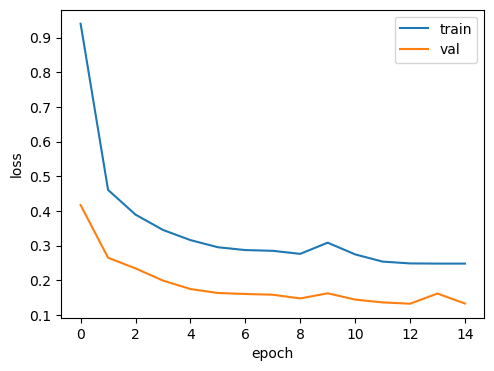

In [48]:
plt.figure(1, (12, 4))
plt.subplot(1, 2, 1)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

In [49]:
preds = model.predict(test_scaled, verbose=1)
preds = tf.squeeze(preds)

1/1 [==============================] - 0s 212ms/step


In [50]:
preds_rescaled = standardscaler.inverse_transform(preds)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


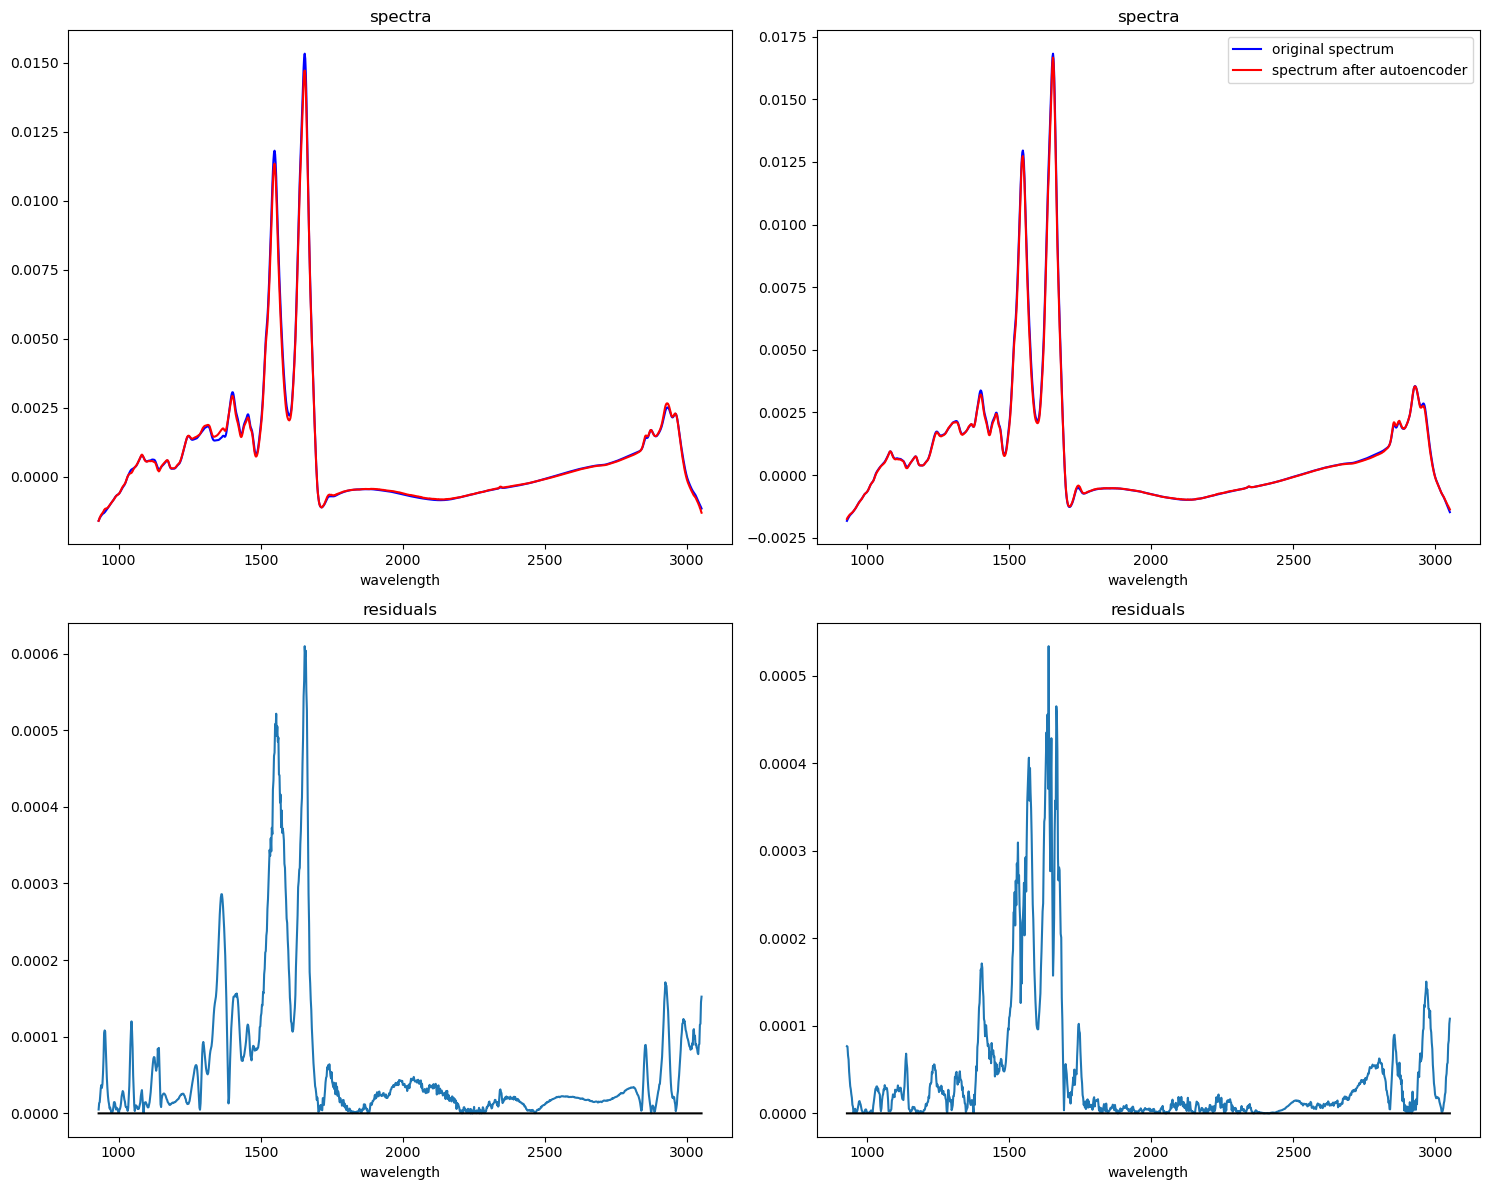

In [51]:
plots = 2
n_test = test.shape[0]
idx = np.random.choice(n_test, plots)
xaxis = np.linspace(929.52720343237377,3050.8548461203636,test.shape[1])

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=plots, figsize=(15,12))

for i in range(plots):
    ax1[i].plot(xaxis, test[idx[i]],'b', markersize= 0.5, label="original spectrum")
    ax1[i].plot(xaxis, preds_rescaled[idx[i]], 'r', markersize=0.5, label="spectrum after autoencoder")
    
    ax1[1].legend(loc=1)
    ax1[i].set_xlabel('wavenumber [cm$^-1$]')
    ax2[i].set_xlabel('wavenumber [cm$^-1$]')
    ax1[i].set_ylabel('absorbance [a.u.]')
    ax1[i].set_title("spectra")

    ax2[i].plot(xaxis, np.abs(test[idx[i]]-preds_rescaled[idx[i]]), label="residuals")
    ax2[i].plot(xaxis, np.zeros(xaxis.shape), 'k')
    
    ax2[i].set_title("residuals")
    
plt.tight_layout()
plt.show()

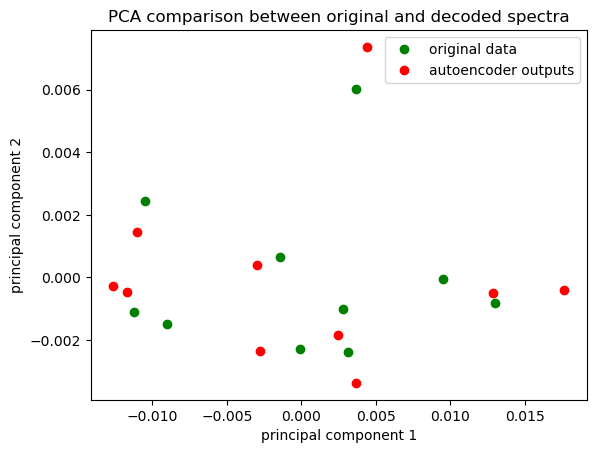

In [52]:
import pandas as pd
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

#performing PCA on the examples
principalComponents = pca.fit_transform(test)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

#passing the examples to the autoencoder and performing PCA again
principalComponents_preds = pca.fit_transform(preds_rescaled)
principalDf_preds = pd.DataFrame(data = principalComponents_preds, columns = ['principal component 1', 'principal component 2'])

#plotting the results
xaxis = list(principalDf["principal component 1"])
yaxis = list(principalDf["principal component 2"])
xaxis_preds = list(principalDf_preds["principal component 1"])
yaxis_preds = list(principalDf_preds["principal component 2"])

plt.plot(xaxis, yaxis, 'go', label = "original data ")
plt.plot(xaxis_preds, yaxis_preds, 'ro', label = "autoencoder outputs")
plt.title("PCA comparison between original and decoded spectra")
plt.xlabel("principal component 1")
plt.ylabel("principal component 2")
plt.legend()